# Authorship Identification

Authorship identification is indeed a huge field and is applicable across multiple domains.

This holds it application everywhere like forensics, mythologies, online messages, ancient belongings, etc.

For now, we shall limit our practive with the minimum dataset. The attached dataset holds for only three authors and they are:

Edgar Allan Poe [EAP] Howard Phillips Lovecraft [HWS] Mary Wollstonecraft Shelley [MWS] About authors Edgar Allan Poe was an American writer, editor, and literary critic. He is best known for his poetry and short stories, particularly his tales of mystery and the macabre.

Howard Phillips Lovecraft was an American writer who achieved posthumous fame through his influential works of horror fiction.

Mary Wollstonecraft Shelley was an English novelist, short story writer, dramatist, essayist, biographer, and travel writer, best known for her Gothic novel Frankenstein: or, The Modern Prometheus.

In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import nltk
import random
import xgboost as xgb

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as plt

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# N- Grams
from nltk.util import ngrams
from collections import Counter

# Topic Modeling
##Feature Extraction
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn import ensemble, metrics, model_selection, naive_bayes

# Word 2 Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Models
import datetime
from nltk import naivebayes

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Read Data
train = pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')

In [3]:
pd.set_option('max_colwidth', 500)
train.text= train.text.astype(str)
train.author = pd.Categorical(train.author)
train.iloc[:20,:]

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
5,id22965,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",MWS
6,id09674,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,"I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not avoid casting your eyes upward to the great nebula in Orion, and I certainly expected that you would do so.",EAP
9,id00912,"I confess that neither the structure of languages, nor the code of governments, nor the politics of various states possessed attractions for me.",MWS


In [4]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    words = [ps.stem(w) for w in words] #4
    words = [lemmatizer.lemmatize(w) for w in words]#5

    return words

def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    print(rslt)

In [5]:
# test case to see if our stemmering and lemmatization is running sussefully
print("The stemmed form of running is: {}".format(ps.stem("running")))
print("The stemmed form of knives is: {}".format(ps.stem("knives")))
print("The lemmatized form of knives is: {}".format(lemmatizer.lemmatize("knives")))


The stemmed form of running is: run
The stemmed form of knives is: knive
The lemmatized form of knives is: knife


In [6]:
print(nltk.word_tokenize(train.text[0]))

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


In [7]:
stop_words = set(stopwords.words("english"))
stop_words
len(stop_words)


179

In [8]:
# Function
def cloud(text, title):
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
    #mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
   # words = lemmatizer.lemmatize(x) # Redundant

    wordcloud = WordCloud(width=1400, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(" ".join(text))
    
    # Output Visualization
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=50,color='y')
    #fig.savefig("wordcloud.png", dpi=900)

None


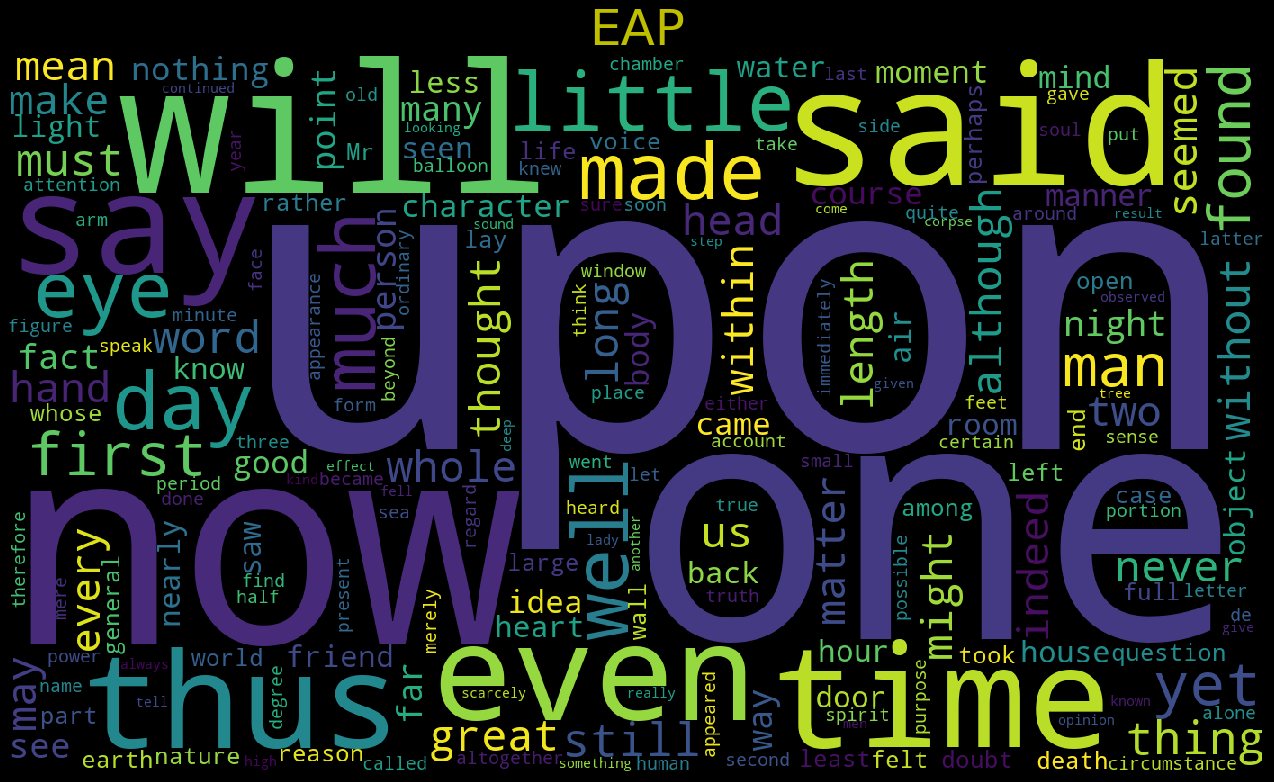

In [9]:
x = "EAP"
print(cloud(train[train.author == x]['text'].values,x))


None


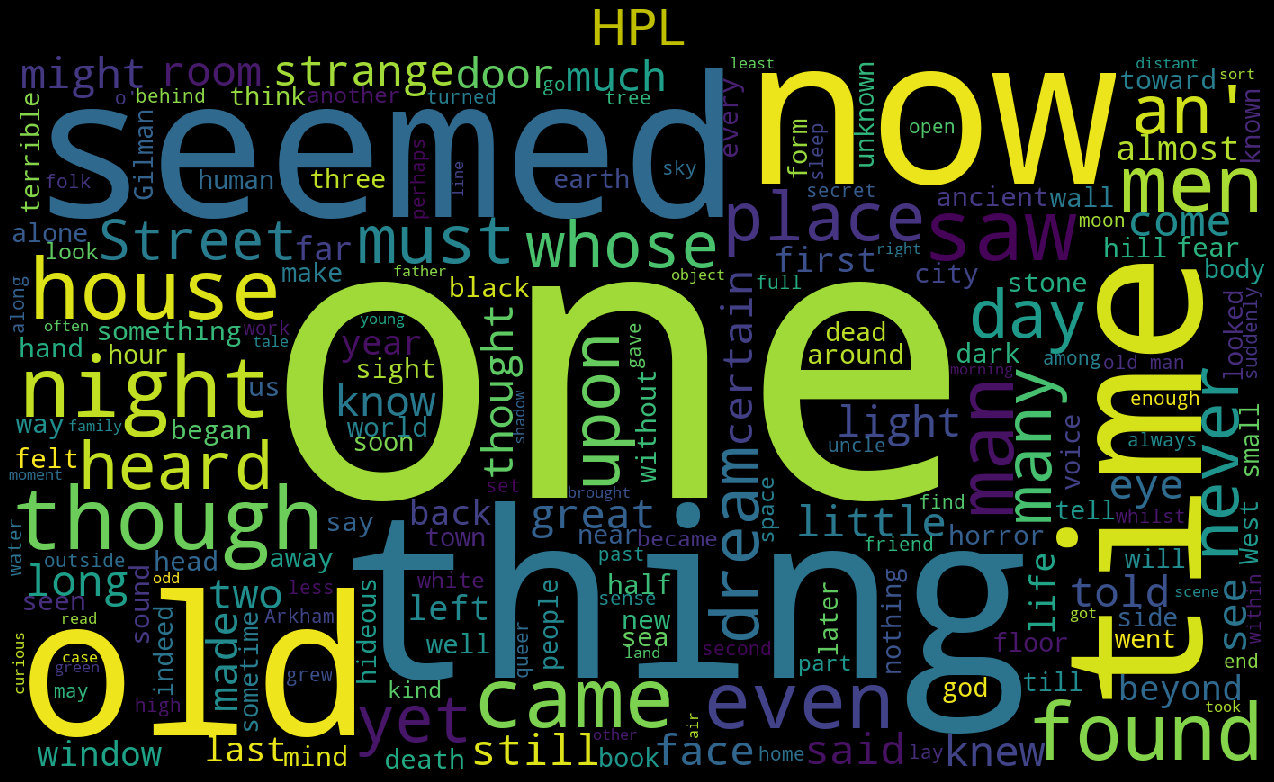

In [10]:
x = "HPL"
print(cloud(train[train.author == x]['text'].values,x))


None


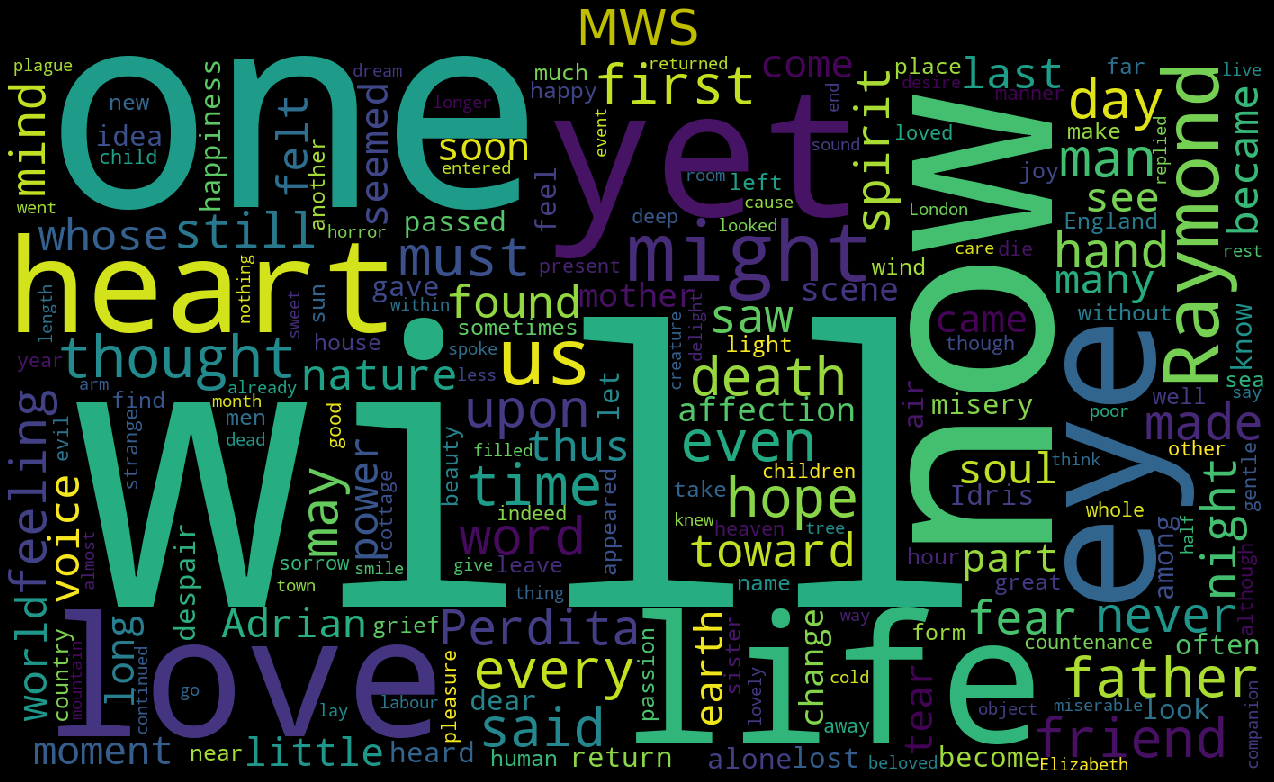

In [11]:
x = "MWS"
print(cloud(train[train.author == x]['text'].values,x))
#if can connect with java script

In [12]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
sentiment = train.copy()
sentiment['polarity_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['compound'])
sentiment['neutral_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['neu'])
sentiment['negative_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['neg'])
sentiment['positive_score']=sentiment.text.apply(lambda x:SIA.polarity_scores(x)['pos'])
sentiment['sentiment']=''
sentiment.loc[sentiment.polarity_score>0,'sentiment']='POSITIVE'
sentiment.loc[sentiment.polarity_score==0,'sentiment']='NEUTRAL'
sentiment.loc[sentiment.polarity_score<0,'sentiment']='NEGATIVE'

# Normalize for Size
auth_sent= sentiment.groupby(['author','sentiment'])[['text']].count().reset_index()
for x in ['EAP','HPL','MWS']:
    auth_sent.text[auth_sent.author == x] = (auth_sent.text[auth_sent.author == x]/\
        auth_sent[auth_sent.author ==x].text.sum())*100


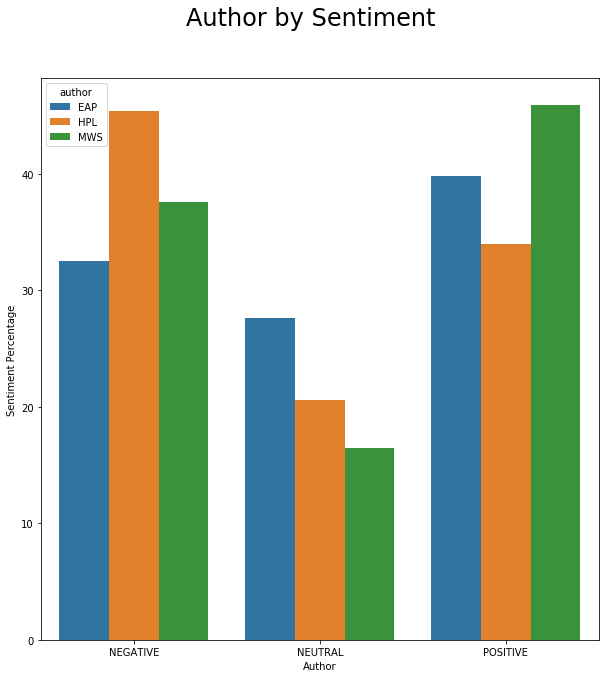

In [13]:
ax= sns.barplot(x='sentiment', y='text',hue='author',data=auth_sent)
ax.set(xlabel='Author', ylabel='Sentiment Percentage')
ax.figure.suptitle("Author by Sentiment", fontsize = 24)
plt.show()


Probability of occurance of the word depends upon the previous word eg: for N=2(bigram) the occurance of the next word depends upon the occcurance of the previous word N-1=1  
For Eg: No.of times chess player occured/No.of times chess occured


In [14]:
## Helper Functions
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting ngrams
    result = get_ngrams(text,n)
    # Counting ngrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(x, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(train[train.author == x]['text']),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurence"]
        out = pd.concat([out, table], axis=1)
    return out


In [15]:
gram_table(x="EAP", gram=[1,2,3,4], length=30)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,upon,1025,let u,50,madam l espanay,12,gener john b c,12
1,one,672,look upon,33,gener john b,12,brigadi gener john b,7
2,could,453,l etoil,23,john b c,12,ugh ugh ugh ugh,6
3,would,409,one two,23,ha ha ha,11,brevet brigadi gener john,6
4,said,356,three four,23,barrièr du roul,10,john b c smith,6
5,say,334,ha ha,22,ugh ugh ugh,8,angl forti five degre,5
6,time,315,everi thing,22,mill mill mill,7,twenti four thousand mile,4
7,even,295,old man,21,de l omelett,7,bring practic nice relat,4
8,littl,277,said dupin,21,forti five degre,7,thrown water immedi death,4
9,eye,270,main compart,21,brigadi gener john,7,relat size proport color,4


In [16]:
gram_table(x="HPL", gram=[1,2,3,4], length=20)

,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,one,516,old man,59,terribl old man,9,eric moreland clapham lee,4
1,could,480,could see,31,heh heh heh,9,oonai citi lute danc,4
2,thing,433,one night,23,charl le sorcier,8,mad arab abdul alhazr,4
3,old,392,old woman,22,small pane window,8,necronomicon mad arab abdul,4
4,would,357,one might,19,great great great,6,aira citi marbl beryl,4
5,seem,317,one could,18,cap n obe,5,villag plain edg bog,3
6,like,296,shun hous,17,citi marbl beryl,5,sir eric moreland clapham,3
7,time,281,next day,17,mad arab abdul,4,heh heh heh heh,3
8,man,280,heh heh,17,oonai citi lute,4,nithra fall tini kra,3
9,night,265,new england,16,basalt pillar west,4,region sea meet sky,3


In [17]:
gram_table(x="MWS", gram=[1,2,3,4], length=20)


,1-Gram,Occurence,2-Gram,Occurence,3-Gram,Occurence,4-Gram,Occurence
0,one,489,old man,29,let u go,4,accus caus death brother,2
1,would,475,lord raymond,28,whole human race,3,five year old mother,2
2,love,426,fellow creatur,23,time lord raymond,3,one day may claim,2
3,could,383,one day,21,nearli two year,3,noth pain human mind,2
4,life,334,nativ countri,16,five year old,3,abod near hyde park,2
5,yet,318,let u,16,might one day,3,like thousand pack wolv,2
6,even,298,everi day,15,creat anoth like,3,smile play upon lip,2
7,heart,290,day night,15,first rank among,3,becom one among fellow,2
8,day,288,look upon,14,return nativ countri,3,nearest town took post,2
9,eye,286,taken place,14,chang taken place,3,day may claim hand,2


#### Meta features

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words


In [18]:
stop_words = set(stopwords.words("english"))
stop_words
len(stop_words)

179

In [19]:
## number of words in text 
train['num_words'] = train['text'].apply(lambda x : len(str(x).split()))
test['num_words'] = test['text'].apply(lambda x : len(str(x).split()))

## number of unique words in the text 
train['unique_words'] = train['text'].apply(lambda x : len(set(str(x).split())))
test['unique_words'] = test['text'].apply(lambda x : len(set(str(x).split())))

## num of characters in the text
train['char'] = train['text'].apply(lambda x : len(str(x)))
test['char'] = test['text'].apply(lambda x : len(str(x)))

## num of stop_words
train['stop_words'] = train['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in stop_words]))
test['stop_words'] = test['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in stop_words]))

## num of punctuations 
train['punc'] = train['text'].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))
test['punc'] = test['text'].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))

## num of upper case words
train['upper_case'] = train['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test['upper_case'] = test['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## number of title case words 
train['title_case'] = train['text'].apply(lambda x : len([c for c in str(x).split() if c.istitle()]))
test['title_case'] = test['text'].apply(lambda x : len([c for c in str(x).split() if c.istitle()]))

## average len words 
train['avg_words'] = train['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test['avg_words'] = test['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

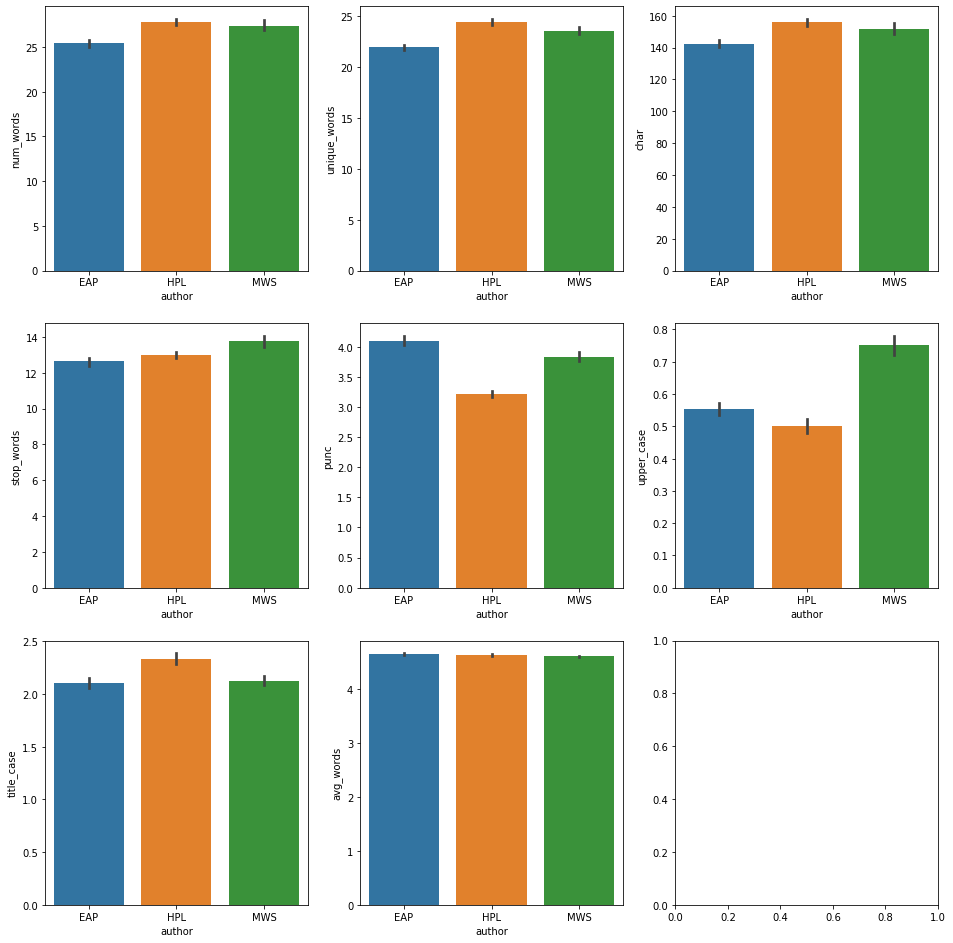

In [20]:
## plot some graphs based on some new features 
#features = ['num_words','unique_word','char','stop_words','punc','upper_case','title_case','mean_words']
_, axes = plt.subplots(3,3, figsize=(16,16))
axes = axes.flatten()
sns.barplot(x = 'author' , y = 'num_words' , data = train,ax=axes[0])
sns.barplot(x = 'author' , y = 'unique_words' , data = train,ax=axes[1])
sns.barplot(x = 'author' , y = 'char' , data = train,ax=axes[2])
sns.barplot(x = 'author' , y = 'stop_words' , data = train,ax=axes[3])
sns.barplot(x = 'author' , y = 'punc' , data = train,ax=axes[4])
sns.barplot(x = 'author' , y = 'upper_case' , data = train,ax=axes[5])
sns.barplot(x = 'author' , y = 'title_case' , data = train,ax=axes[6])
sns.barplot(x = 'author' , y = 'avg_words' , data = train,ax=axes[7])

#for i, feature in enumerate(features):
#    sns.barplot(x='author', y=feature, data=train, ax=axes[int(i/3),i%3])
#plt.show()

In [21]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train['author'].map(author_mapping_dict)
train_id = train['id'].values
test_id = test['id'].values
cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

In [22]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [23]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04656	test-mlogloss:1.05725
[40]	train-mlogloss:1.02352	test-mlogloss:1.03846
[60]	train-mlogloss:1.01104	test-mlogloss:1.02956
[80]	train-mlogloss:0.998264	test-mlogloss:1.01959
[100]	train-mlogloss:0.989371	test-mlogloss:1.01364
[120]	train-mlogloss:0.982025	test-mlogloss:1.00849
[140]	train-mlogloss:0.975944	test-mlogloss:1.00511
[160]	train-mlogloss:0.970939	test-mlogloss:1.0027
[180]	train-mlogloss:0.966114	test-mlogloss:1.00048
[200]	train-mlogloss:0.961259	test-mlogloss:0.997975
[220]	train-mlogloss:0.95742	test-mlogloss:0.996858
[240]	train-mlogloss:0.953737	test-mlogloss:0.995286
[260]	train-mlogloss:0.950356	test-mlogloss:0.993982
[280]	train-mlogloss:0.947118	test-mlogloss:0.993222
[300]	train-mlogloss:0.943786	test-mlogloss:0.992595
[320]	train-mlogloss:0.

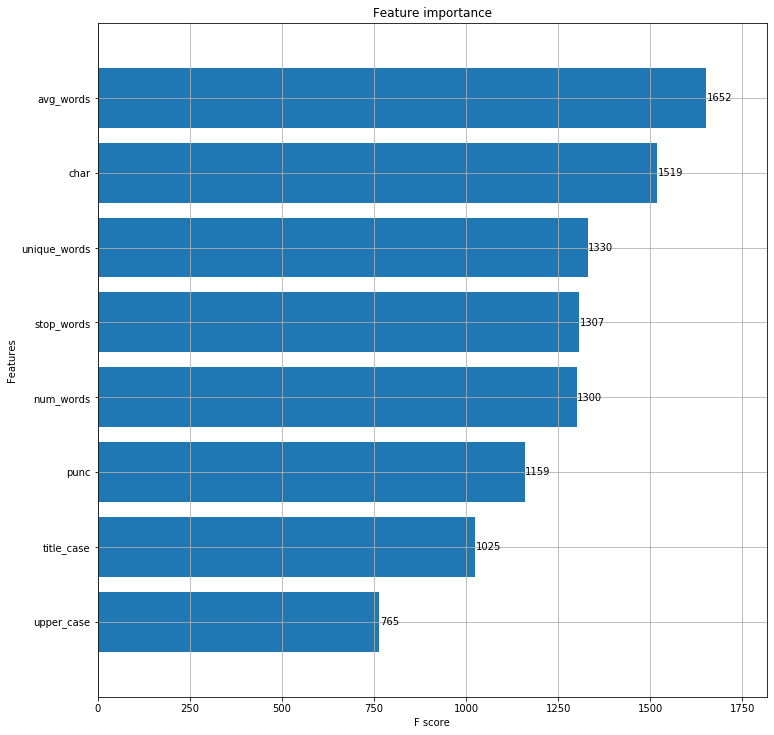

In [24]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Number of characters, mean word length and number of unique words turn out to be the top 3 variables. Now let us focus on creating some text based features.



Text Based Features :

One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.

#### Naive Bayes on tf-idf

In [25]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,4))
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [26]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [27]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.


Mean cv score :  0.8767880623256687


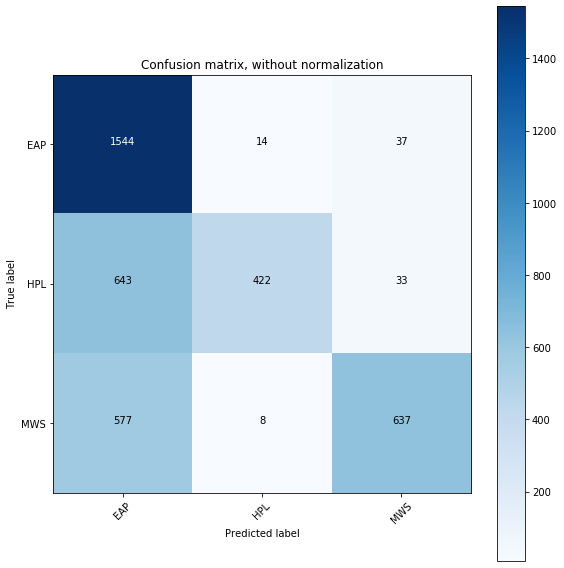

In [28]:
### Function to create confusion matrix for accuracy ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()


#### Naive Bayes on Word Count Vectorizer

In [29]:
### Fit transform the count vectorizer ###
count_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
full_count =count_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_count = count_vec.transform(train['text'].values.tolist())
test_count = count_vec.transform(test['text'].values.tolist())
#CountVectorizer

In [30]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_count[dev_index], train_count[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_count)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train["nb_cvec_eap"] = pred_train[:,0]
train["nb_cvec_hpl"] = pred_train[:,1]
train["nb_cvec_mws"] = pred_train[:,2]
test["nb_cvec_eap"] = pred_full_test[:,0]
test["nb_cvec_hpl"] = pred_full_test[:,1]
test["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.4513706155662227


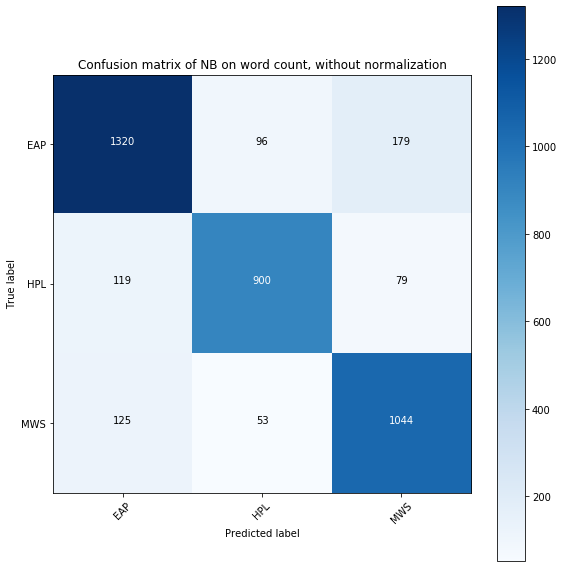

In [31]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [32]:
cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00721	test-mlogloss:1.00717
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.468344	test-mlogloss:0.473616
[40]	train-mlogloss:0.39889	test-mlogloss:0.409045
[60]	train-mlogloss:0.379885	test-mlogloss:0.394693
[80]	train-mlogloss:0.370066	test-mlogloss:0.389836
[100]	train-mlogloss:0.362704	test-mlogloss:0.387087
[120]	train-mlogloss:0.356983	test-mlogloss:0.385813
[140]	train-mlogloss:0.351655	test-mlogloss:0.384465
[160]	train-mlogloss:0.346821	test-mlogloss:0.384119
[180]	train-mlogloss:0.342618	test-mlogloss:0.38377
[200]	train-mlogloss:0.338661	test-mlogloss:0.383339
[220]	train-mlogloss:0.334734	test-mlogloss:0.383207
[240]	train-mlogloss:0.331028	test-mlogloss:0.382942
[260]	train-mlogloss:0.32687	test-mlogloss:0.38331
[280]	train-mlogloss:0.323273	test-mlogloss:0.38365
Stopping. Best iteration:
[234]	train-mlogloss:0.332093	test-mloglo

In [33]:
from IPython.display import FileLink, FileLinks


#FileLinks('.')
out_df.to_csv('C:/Users/Anisha/Documents/spooky-author-identification/output/sub_fe.csv', index=False)
FileLinks('C:/Users/Anisha/Documents/spooky-author-identification/output')

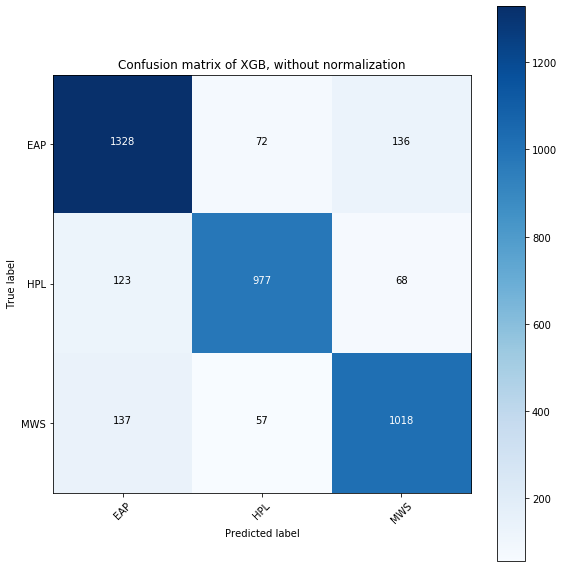

In [34]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

#### Logistic Regression

In [35]:
X = train['text']
y = train['author']

In [36]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=8)
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=8, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(15663,) (15663,) (3916,) (3916,)


In [38]:
print(train_y.value_counts(),'\n', test_y.value_counts())

EAP    6330
MWS    4800
HPL    4533
Name: author, dtype: int64 
 EAP    1570
MWS    1244
HPL    1102
Name: author, dtype: int64


In [39]:
# import and instantiate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# vect = CountVectorizer()
vect = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\;|\:')
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None,
                token_pattern='(?u)\\b\\w+\\b|\\,|\\.|\\;|\\:', tokenizer=None,
                vocabulary=None)

In [40]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
train_X_dtm = vect.fit_transform(train_X)
# examine the document-term matrix created from X_train
train_X_dtm

<15663x25199 sparse matrix of type '<class 'numpy.int64'>'
	with 392246 stored elements in Compressed Sparse Row format>

In [41]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<3916x25199 sparse matrix of type '<class 'numpy.int64'>'
	with 94560 stored elements in Compressed Sparse Row format>

In [42]:
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')


In [43]:
from string import punctuation
train_X_chars = train_X.str.len()
train_X_punc = train_X.apply(lambda x: len([c for c in str(x) if c in punctuation]))
test_X_chars = test_X.str.len()
test_X_punc = test_X.apply(lambda x: len([c for c in str(x) if c in punctuation]))
train_X_dtm = add_feature(train_X_dtm, [train_X_chars, train_X_punc])
test_X_dtm = add_feature(test_X_dtm, [test_X_chars, test_X_punc])


In [44]:
train_X_dtm

<15663x25201 sparse matrix of type '<class 'numpy.int64'>'
	with 423572 stored elements in Compressed Sparse Row format>

In [45]:
test_X_dtm

<3916x25201 sparse matrix of type '<class 'numpy.int64'>'
	with 102392 stored elements in Compressed Sparse Row format>

In [46]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=8)
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=8, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
grid_values = {'C':[0.01, 0.1, 1.0, 3.0, 5.0]}
grid_logreg = GridSearchCV(logreg, param_grid=grid_values, scoring='neg_log_loss')
grid_logreg.fit(train_X_dtm, train_y)
grid_logreg.best_params_

{'C': 1.0}

In [49]:
# set with recommended parameter
logreg = LogisticRegression(C=1.0, random_state=8)
# train the model using train_X_dtm & train_y
logreg.fit(train_X_dtm, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=8, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
# make class predictions for test_X_dtm
y_pred_test = logreg.predict(test_X_dtm)

In [51]:
# look at the confusion matrix for y_test
metrics.confusion_matrix(test_y, y_pred_test)

array([[1353,   96,  121],
       [ 147,  899,   56],
       [ 173,   56, 1015]], dtype=int64)

In [52]:
# compute the predicted probabilities for X_test_dtm
y_pred_prob = logreg.predict_proba(test_X_dtm)
y_pred_prob[:10]

array([[6.97e-02, 2.95e-02, 9.01e-01],
       [8.58e-02, 5.37e-01, 3.77e-01],
       [7.70e-01, 2.30e-01, 8.83e-04],
       [4.81e-02, 9.02e-01, 5.03e-02],
       [8.65e-01, 1.03e-01, 3.16e-02],
       [9.96e-01, 3.54e-03, 3.65e-04],
       [8.77e-01, 3.60e-03, 1.19e-01],
       [3.63e-01, 1.79e-01, 4.58e-01],
       [5.75e-01, 5.71e-02, 3.68e-01],
       [4.66e-01, 4.50e-01, 8.35e-02]])

In [53]:
metrics.log_loss(test_y, y_pred_prob)

0.4377388960606754

In [54]:
train = pd.read_csv('./train.csv')
## look at the first few rows
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [55]:
### Split data

# split the data by author
byAuthor = train.groupby("author")

### Tokenize (split into individual words) our text

# word frequency by author
wordFreqByAuthor = nltk.probability.ConditionalFreqDist()

# for each author...
for name, group in byAuthor:
    # get all of the sentences they wrote and collapse them into a
    # single long string
    sentences = group['text'].str.cat(sep = ' ')
    
    # convert everything to lower case (so "The" and "the" get counted as 
    # the same word rather than two different words)
    sentences = sentences.lower()
    
    # split the text into individual tokens    
    tokens = nltk.tokenize.word_tokenize(sentences)
    
    # calculate the frequency of each token
    frequency = nltk.FreqDist(tokens)

    # add the frequencies for each author to our dictionary
    wordFreqByAuthor[name] = (frequency)
    
# now we have an dictionary where each entry is the frequency distrobution
# of words for a specific author.     

In [56]:
# see how often each author says "blood"
for i in wordFreqByAuthor.keys():
    print("blood: " + i)
    print(wordFreqByAuthor[i].freq('blood'))

# print a blank line
print()

# see how often each author says "scream"
for i in wordFreqByAuthor.keys():
    print("scream: " + i)
    print(wordFreqByAuthor[i].freq('scream'))
    
# print a blank line
print()

# see how often each author says "fear"
for i in wordFreqByAuthor.keys():
    print("fear: " + i)
    print(wordFreqByAuthor[i].freq('fear'))
# print a blank line
print()

# see how often each author says "upon"
for i in wordFreqByAuthor.keys():
    print("upon: " + i)
    print(wordFreqByAuthor[i].freq('upon'))

blood: EAP
0.00014645324695463396
blood: HPL
0.0002298361842596689
blood: MWS
0.00022772649518331984

scream: EAP
1.72297937593687e-05
scream: HPL
9.193447370386757e-05
scream: MWS
2.647982502131626e-05

fear: EAP
0.0001033787625562122
fear: HPL
0.0005745904606491723
fear: MWS
0.0006196279054988005

upon: EAP
0.004415134650838229
upon: HPL
0.0010687382568074606
upon: MWS
0.0010591930008526504


In [57]:
# first, let's start with a test sentence
testSentence = "This process, however, afforded me no means of ascertaining the dimensions of my dungeon"

# and then lowercase & tokenize our test sentence
preProcessedTestSentence = nltk.tokenize.word_tokenize(testSentence.lower())

# create an empy dataframe to put our output in
testProbailities = pd.DataFrame(columns = ['author','word','probability'])

# For each author...
for i in wordFreqByAuthor.keys():
    # for each word in our test sentence...
    for j  in preProcessedTestSentence:
        # find out how frequently the author used that word
        wordFreq = wordFreqByAuthor[i].freq(j)
        # and add a very small amount to every prob. so none of them are 0
        smoothedWordFreq = wordFreq + 0.000001
        # add the author, word and smoothed freq. to our dataframe
        output = pd.DataFrame([[i, j, smoothedWordFreq]], columns = ['author','word','probability'])
        testProbailities = testProbailities.append(output, ignore_index = True)

# empty dataframe for the probability that each author wrote the sentence
testProbailitiesByAuthor = pd.DataFrame(columns = ['author','jointProbability'])

# now let's group the dataframe with our frequency by author
for i in wordFreqByAuthor.keys():
    # get the joint probability that each author wrote each word
    oneAuthor = testProbailities.query('author == "' + i + '"')
    jointProbability = oneAuthor.product(numeric_only = True)[0]
    
    # and add that to our dataframe
    output = pd.DataFrame([[i, jointProbability]], columns = ['author','jointProbability'])
    testProbailitiesByAuthor = testProbailitiesByAuthor.append(output, ignore_index = True)

# and our winner is...
testProbailitiesByAuthor.loc[testProbailitiesByAuthor['jointProbability'].idxmax(),'author']

'EAP'